In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt


#read in + edit SP 500 value
sp500_df = pd.read_csv("sp500adj.csv")
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
sp500_df['date_month'] = sp500_df['Date'].dt.strftime('%Y.%m')
sp500_df = sp500_df.rename(columns={"Value":"SP500 Index Value ($)"})
#sp500_df


#read in + edit geopolitical risk (GPR)
#"Higher geopolitical risk foreshadows lower investment, stock prices, and employment"
gpr_df_raw = pd.read_csv("data_gpr_export.csv")
gpr_df_raw['Date'] = pd.to_datetime(gpr_df_raw['month'])
gpr_df_raw['date_month'] = gpr_df_raw['Date'].dt.strftime('%Y.%m')
us_gpr_df = gpr_df_raw[['date_month','GPRC_USA']]


#read in + edit GDP with inflation adjusted
#note: had to remove first two lines in the dataset in order to actually read it
#those only contained the data source and last edit time:
#"Data Source","World Development Indicators",
#"Last Updated Date","2025-10-07",
GDP_df = pd.read_csv("GDP/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_130122.csv")
GDP_df = GDP_df[GDP_df['Country Code'] == 'USA']
gdp_usa = GDP_df.melt(
    id_vars=['Country Code','Country Name','Indicator Name','Indicator Code'],
    var_name='Year', value_name='GDP'
)
gdp_usa = gdp_usa.rename(columns={"GDP":"US GDP inflation adjusted ($)"})
gdp_usa = gdp_usa[gdp_usa['Year'].str.isnumeric()].copy()
gdp_usa['Year'] = gdp_usa['Year'].astype(int)
#gdp_usa


#read in + edit federal funds rate
fed_df = pd.read_csv("FEDFUNDS.csv")
fed_df['observation_date'] = pd.to_datetime(fed_df['observation_date'])
fed_df['Year'] = fed_df['observation_date'].dt.year
fed_df['FEDFUNDS'] = pd.to_numeric(fed_df['FEDFUNDS'], errors='coerce')
fed_df = fed_df.groupby('Year', as_index=False)['FEDFUNDS'].mean()


#merging all the dataframes (by year)
merged_df = pd.merge(sp500_df, us_gpr_df, on='date_month', how='inner').dropna()
merged_df['Year'] = merged_df['Date'].dt.year
annual_df = merged_df.groupby('Year', as_index=False).agg({
    'SP500 Index Value ($)': 'mean',
    'GPRC_USA': 'mean'
})
merged_yearly_df = pd.merge(annual_df, gdp_usa[['Year','US GDP inflation adjusted ($)']], on='Year', how='inner')
merged_yearly_df = pd.merge(merged_yearly_df, fed_df, on='Year', how='left')
#merged_yearly_df


#merging all the datasets (by year + month, doesn't include GDP)
merged_df = pd.merge(sp500_df, us_gpr_df, on='date_month', how='inner').dropna()
fed_df = pd.read_csv("FEDFUNDS.csv")
fed_df['observation_date'] = pd.to_datetime(fed_df['observation_date'])
fed_df['date_month'] = fed_df['observation_date'].dt.strftime('%Y.%m')
fed_df = fed_df[['date_month', 'FEDFUNDS']]
merged_monthly_df = pd.merge(merged_df, fed_df, on='date_month', how='left')
merged_monthly_df = merged_monthly_df.sort_values('Date')
merged_monthly_df = merged_monthly_df.set_index('Date')
#merged_monthly_df

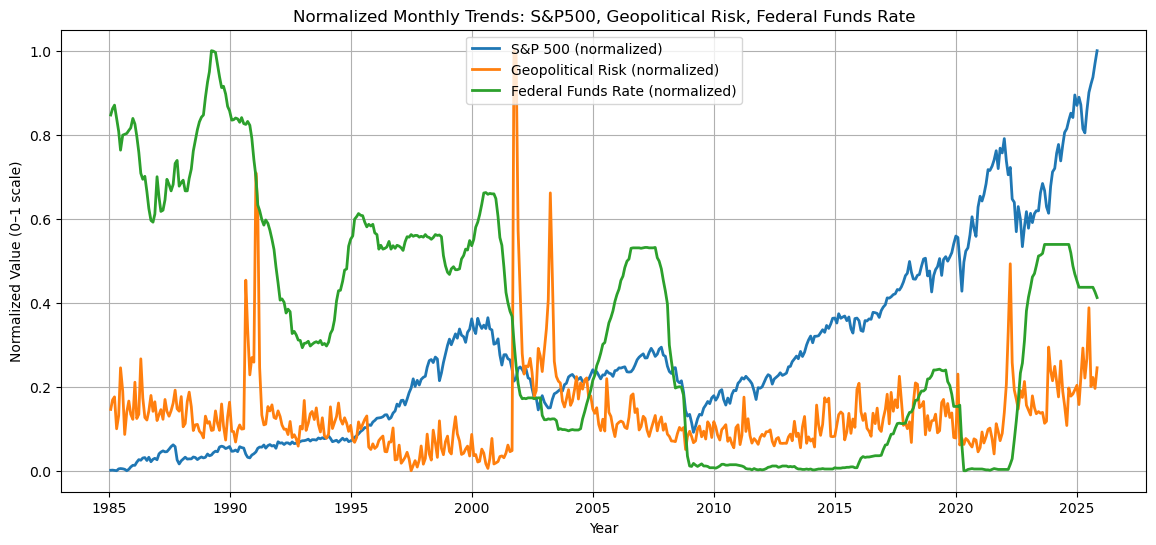

In [ ]:
normalized_df = merged_monthly_df.copy()
for col in ['SP500 Index Value ($)', 'GPRC_USA', 'FEDFUNDS']:
    normalized_df[col + '_norm'] = (
        normalized_df[col] - normalized_df[col].min()
    ) / (normalized_df[col].max() - normalized_df[col].min())

plt.figure(figsize=(14,6))
plt.plot(normalized_df.index, normalized_df['SP500 Index Value ($)_norm'], label='S&P 500 (normalized)', linewidth=2)
plt.plot(normalized_df.index, normalized_df['GPRC_USA_norm'], label='Geopolitical Risk (normalized)', linewidth=2)
plt.plot(normalized_df.index, normalized_df['FEDFUNDS_norm'], label='Federal Funds Rate (normalized)', linewidth=2)

plt.title("Normalized Monthly Trends: S&P500, Geopolitical Risk, Federal Funds Rate")
plt.xlabel("Year")
plt.ylabel("Normalized Value (0–1 scale)")
plt.legend()
plt.grid(True)
plt.show()

#during spikes in GPR there are sometimes falls in the economy?
#something to investigate might be growth/loss in the SP 500 instead of just total value